In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Approach

First, set up plain convolutional network with single label. Then change from single label to phonemes. In phoneomes model, run test samples through trained model to get vector of probabilities for each phoneme and then calculate least distance to average of vectors from training set. Could use a layer before the final layer to have more points in the vector from which to calculate distance. Could also do this when minimizing loss with respect to single label.

Ok to use test data - then perform predictions on test set and include test samples above likelihood threshold 

Reduce dimensionality by limiting frequencies to something approximating human voice range (need to make sure to include wide enough range to include children).

Explore possibility of removing noise from samples before training and testing.

Explore idea of using convolutional object detection algorithm to learn information about the location of phonemes.

Explore possibility of removing either left or right channel or averaging in order to reduce dimensionality.

Explore possibility of stacking deltas and/or other features in different channels.

Use different speaker utterances as a sample for how to artificially distort samples.

Explore possibility of identifying samples with "noise" in them - investigate whether samples have any noise in them (believe they do not), in which case curriculum learning could be applied to train the model first on clean samples and then add noise and distortion for further training to make it more robust.

Consider training on just complete sets of utterances from speakers. There were 1,249 speakers that had a complete set of utterances.

Explore possibility of using [GAN](https://arxiv.org/pdf/1701.00160.pdf) to add in competitive noise and distortion. [KL](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)

Normalization - relative differences in amplitude in a frame are what determine speech - need to determine best method for [matching volumes across samples](https://www.learndigitalaudio.com/normalize-audio).

#### Data Exploration
Look at distribution of spectrograms.
Clustering analysis.
Clustering analysis on training set.
Look at spectrograms

#### Spectrograms
For the speech regions, we generate 40-dimensional logfilterbank energies computed every 10 ms over a window of 25ms.
[Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

#### Noise Generation
Next, we created noisy training and evaluation sets by artificially adding car and cafeteria noise at SNRs randomly sampled between [-5dB, +10dB] to the clean data sets.

#### Convolutions
Need to decide on windows and strides from time and frequency dimensions for convolutions and pooling.

#### Research papers
[Convolutional Neural Networks for Small-footprint Keyword Spotting](http://www.isca-speech.org/archive/interspeech_2015/papers/i15_1478.pdf)

[Query-By-Example Keyword Spotting Using Long Short-Term Memory Networks](http://www.clsp.jhu.edu/~guoguo/papers/icassp2015_myhotword.pdf)

[Small-Footprint Keyword Spotting Using Deep Neural Network And Connectionist Temporal Classifier](https://arxiv.org/pdf/1709.03665.pdf)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import os, time, math
from tqdm import tnrange, tqdm_notebook
import IPython.display as ipd
from librosa import logamplitude
from librosa.feature import melspectrogram
from librosa.display import specshow, waveplot

from audio_datasets import AudioData, df

Here are all the words with their phonemes.

In [3]:
words = {'bed': 'B EH D',
         'bird': 'B ER D',
         'cat': 'K AE T',
         'dog': 'D AO G',
         'down': 'D AW N',
         'eight': 'EY T',
         'five': 'F AY V',
         'four': 'F AO R',
         'go': 'G OW',
         'happy': 'HH AE P IY',
         'house': 'HH AW S',
         'left': 'L EF F T',
         'marvin': 'M AA R V IH N',
         'nine': 'N AY N',
         'no': 'N OW',
         'off': 'AO F',
         'on': 'AA N',
         'one': 'W AH N',
         'right': 'R AY T',
         'seven': 'S EH V AH N',
         'sheila': 'SH IY L AH',
         'six': 'S IH K S',
         'stop': 'S T AA P',
         'three': 'TH R IY',
         'two': 'T UW',
         'up': 'AH P',
         'wow': 'W AW',
         'yes': 'Y EH S',
         'zero': 'Z IY R OW'}

These is the subset of words to classify the test set into for submission purposes. The test set has had random noise put into it, but I think many or perhaps all of the unknowns will be one of the other words.

In [4]:
words_test = 'yes, no, up, down, left, right, on, off, stop, go, unknown, silence'.split(', ')

In [5]:
all_p = []
for w in words:
    all_p.extend(words[w].split())
all_p = set(all_p)

There are a total of {{len(words.keys())}} and {{len(all_p)}} unique phonemes.

###  Transforms

In [6]:
means, stds = (np.array(x) for x in ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda x: x)]),
    'val': transforms.Compose([
        transforms.Lambda(lambda x: x)]),
    'test': transforms.Compose([
        transforms.Lambda(lambda x: x)]),
    'train_all': transforms.Lambda(lambda x: x)}

### Create dataloaders

In [7]:
splits = ['train', 'val', 'test', 'train_all']
ds = {x: AudioData(x, transform=data_transforms[x]) for x in splits}

In [8]:
bs = 64
dl = {'train': DataLoader(ds['train'], bs, True, num_workers=6),
      'val': DataLoader(ds['val'], bs, True, num_workers=6),
      'val': DataLoader(ds['train_all'], bs, False, num_workers=6),
      'test': DataLoader(ds['test'], bs, False, num_workers=6)}

### Explore Data

In [9]:
df_sc = df['train_all'].groupby(['speaker', 'class_name']).count()

There are a total of {{'{:,.0f}'.format(len(df_sc))}} samples in the training set. Here is a look at the number of training samples by class. It looks like they are reasonably evenly distributed.

In [10]:
def samples_hist(x, title):
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Class'
        ),
        yaxis=dict(
            title='Number of Samples'
        )
    )
    fig = go.Figure(data=[go.Histogram(x=x)], layout=layout)
    iplot(fig)
samples_hist(sorted(df['train_all'].class_name), 'Number of Samples by Class')

There are a total of {{'{:,.0f}'.format(len(df_sc.index.levels[0]))}} speakers. Here is a look at the number of training samples per speaker. Most speakers have between 25 and 35 samples with a max of 209.

In [11]:
layout = go.Layout(
    title='Count of Speakers by Number of Samples',
    xaxis=dict(
        title='Number of Samples'
    ),
    yaxis=dict(
        title='Number of Speakers'
    )
)
fig = go.Figure(data=[go.Histogram(x=df_sc.groupby('speaker').sum().file)], layout=layout)
iplot(fig)

Let's explore the idea of doing our test/validation split by sampling randomly from the speakers. Here we split the speakers 80% training and 20% validation and then plot histograms of the count in each class. This looks like it works as a splitting mechanism; across many iterations the splits across labels was fairly consistent.

In [12]:
# np.random.seed(41)
val_pct = 0.20
speakers = df['train_all'].speaker.unique()
idx = np.random.randint(len(speakers), size = int((len(speakers) * val_pct)))
val = speakers[idx]
samples_hist(sorted(df['train_all'][df['train_all'].speaker.isin(val)]
                    .class_name), 'Number of Samples by Class - Val')
samples_hist(sorted(df['train_all'][df['train_all'].speaker.isin(val)]
                    .class_name), 'Number of Samples by Class - Train')

In [23]:
samples, rate = ds['train'][0][0]
ipd.Audio(samples, rate=rate)

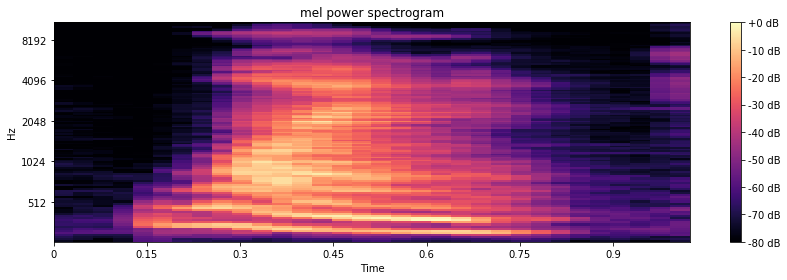

In [38]:
S = melspectrogram(samples, rate)
log_S = logamplitude(S, ref_power=np.max)
# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
specshow(log_S, sr=rate, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

In [39]:
S.shape

(128, 32)